In [1]:
import numpy as np
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [2]:
exp_wind = MultiVarExperiment(
    "ERA5", "plev", ["u", "v", "s"], "6H", (1940, 2022), None, -80, 30, 20, 80, [200, 250, 300]
)
ds = exp_wind.ds
exp_T = Experiment(
    "ERA5", "surf", "t", "6H", (1940, 2022), None, -30, 40, 30, 75, 100, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_T = exp_T.da
exp_pvs = Experiment(
    "ERA5", "surf", "pvs", "6H", (1940, 2022), None, -80, 30, 20, 80, 250, 'hourofyear', {'hourofyear': ('win', 4 * 10)}, None,
)
da_pvs = exp_pvs.da
nao = get_nao(interp_like=ds)

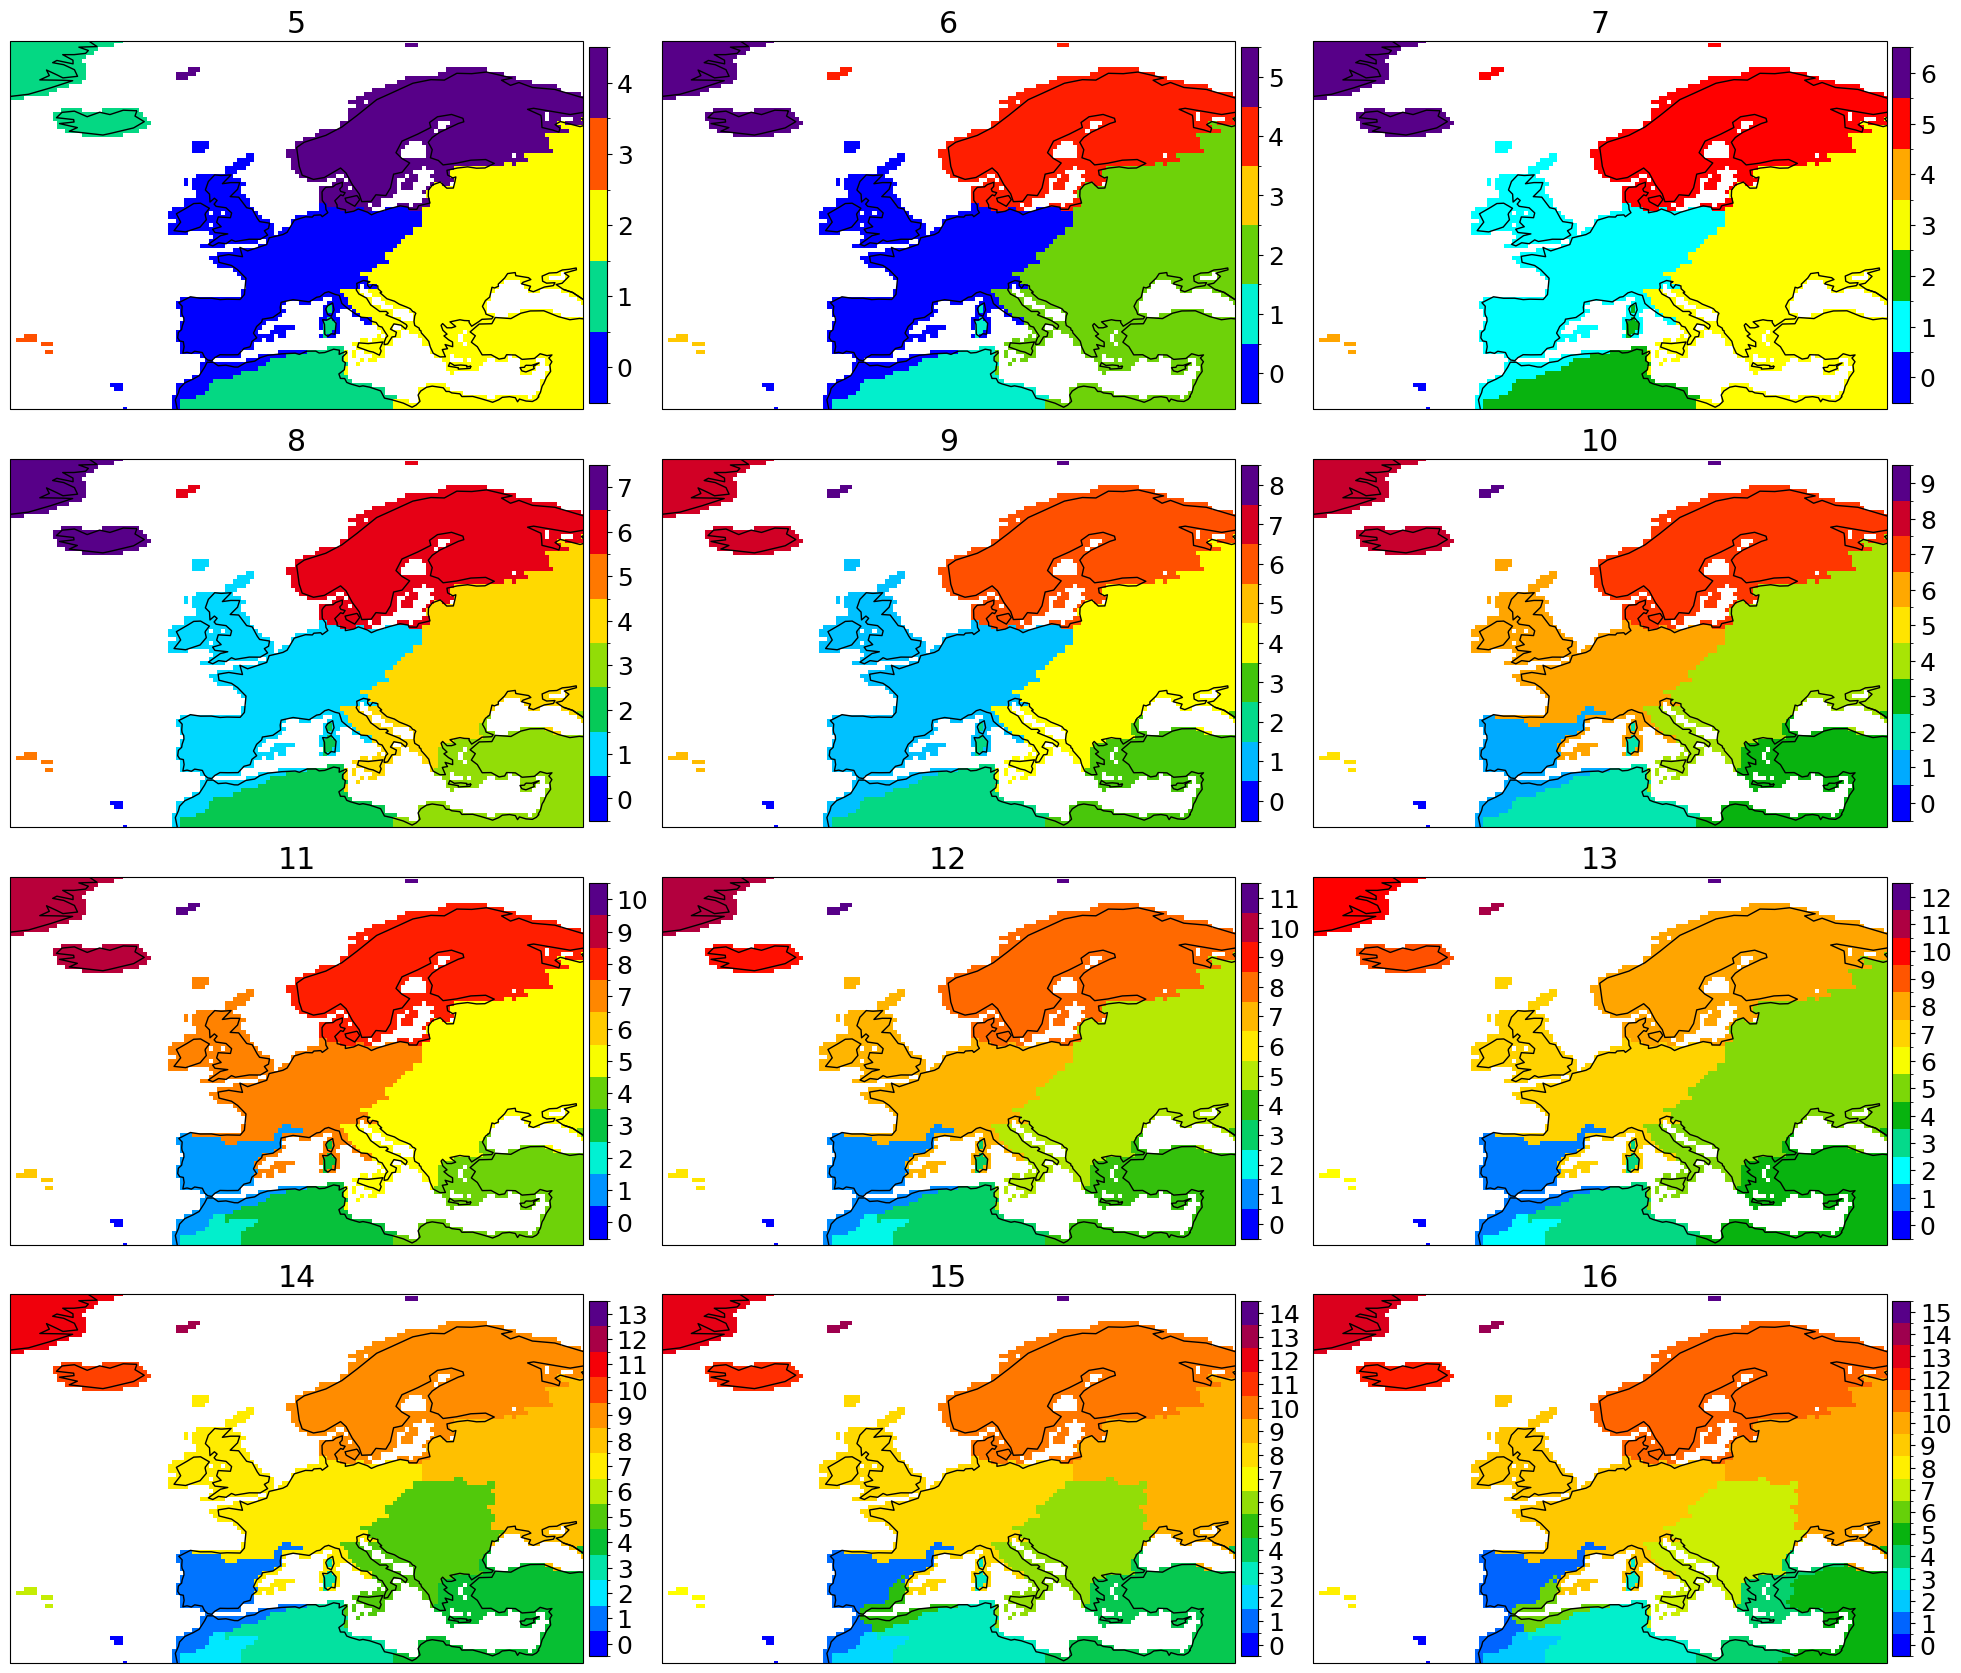

In [14]:
clu = Clusterplot(4, 3, get_region(mask))
cmap = colormaps.BlAqGrYeOrReVi200
for i, n_clu in enumerate(range(5, 17)):
    clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
    clusters_da = np.zeros(mask_flat.shape, dtype=float)
    clusters_da[:] = np.nan
    clusters_da = mask_flat.copy(data=clusters_da)
    clusters_da[mask_flat] = clusters
    unique_clusters = np.unique(clusters)
    norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
    every = n_clu // 20 + 1
    clusters_da.unstack().plot(
        ax=clu.axes[i],
        cmap=cmap,
        add_colorbar=False,
        add_labels=False
    )
    clu.axes[i].set_title(n_clu)
    im = ScalarMappable(cmap=cmap, norm=norm)
    clu.fig.colorbar(im, ax=clu.axes[i], ticks=np.arange(0, n_clu, every), shrink=0.92, pad=0.01)

In [16]:
all_jets = []
props_as_ds_uncat = exp_wind.props_as_ds(categorize=False)
props_as_ds = exp_wind.props_as_ds(categorize=True)
props_as_ds_anoms = compute_prop_anomalies(props_as_ds)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)
da_jet_pos = jet_position_as_da(ds["s"], props_as_ds, props_as_ds_uncat, all_jets, exp_wind.path)
props_as_np = props_as_ds.to_dataarray().values
props_as_np = props_as_np.transpose(1, 0, 2).reshape(props_as_np.shape[1], props_as_np.shape[0] * props_as_np.shape[2]) 
da_cee = exp_T.select_heat_wave_cluster(10, 6)

In [24]:
props_as_ds_masked = mask_from_t(da_cee, props_as_ds, q=0.8, fill_holes=True, time_before=pd.Timedelta(4, 'D'))

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  mask = heat_waves.astype('datetime64[h]').values
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:50: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArr

IndexError: index 0 is out of bounds for axis 0 with size 0

In [29]:
heat_waves_ts, heat_waves = heat_waves_from_t(da_cee, 0.95, output_type="list")

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  mask = heat_waves.astype('datetime64[h]').values
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:50: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArr

In [32]:
months = np.unique(props_as_ds.time.dt.month.values)
months = [str(months[0]).zfill(2), str(min(12, months[-1] + 1)).zfill(2)]
lengths = heat_waves[:, 1] - heat_waves[:, 0]
longest_hotspell = np.argmax(lengths)
time_around_beg = heat_waves_ts[longest_hotspell] - heat_waves[longest_hotspell, 0]
time_around_beg = time_around_beg.values
ds_masked = ds.loc[dict(time=ds.time.values[0])].reset_coords('time', drop=True).copy(deep=True)
ds_masked.loc[dict()] = np.nan
ds_masked = ds_masked.expand_dims(
    heat_wave=np.arange(len(heat_waves)),
    time_around_beg=time_around_beg,
).copy(deep=True)
ds_masked = ds_masked.assign_coords(lengths=('heat_wave', lengths))
dims = list(ds_masked.sizes.values())[:2]
dummy_da = np.zeros(dims) + np.nan
ds_masked = ds_masked.assign_coords(temperature=(['heat_wave', 'time_around_beg'], dummy_da))
ds_masked = ds_masked.assign_coords(absolute_time=(['heat_wave', 'time_around_beg'], dummy_da.astype('datetime64[h]')))

/scratch/local/7312735/ipykernel_76165/1280903878.py:17: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_masked = ds_masked.assign_coords(absolute_time=(['heat_wave', 'time_around_beg'], dummy_da.astype('datetime64[h]')))


In [35]:
heat_waves

array([['1940-11-20T06:00:00.000000000', '1940-11-23T18:00:00.000000000'],
       ['1942-12-19T00:00:00.000000000', '1942-12-24T12:00:00.000000000'],
       ['1948-01-27T12:00:00.000000000', '1948-02-05T06:00:00.000000000'],
       ['1949-11-20T00:00:00.000000000', '1949-11-23T12:00:00.000000000'],
       ['1954-12-12T18:00:00.000000000', '1954-12-18T12:00:00.000000000'],
       ['1957-02-05T12:00:00.000000000', '1957-02-08T18:00:00.000000000'],
       ['1960-01-01T00:00:00.000000000', '1960-01-07T00:00:00.000000000'],
       ['1961-02-20T12:00:00.000000000', '1961-02-28T06:00:00.000000000'],
       ['1971-01-22T00:00:00.000000000', '1971-01-26T06:00:00.000000000'],
       ['1975-01-28T06:00:00.000000000', '1975-02-04T12:00:00.000000000'],
       ['1983-01-06T12:00:00.000000000', '1983-01-09T12:00:00.000000000'],
       ['1983-01-26T00:00:00.000000000', '1983-01-29T00:00:00.000000000'],
       ['1989-04-11T00:00:00.000000000', '1989-04-15T00:00:00.000000000'],
       ['1990-01-24T06:00

In [34]:
heat_waves_ts

[DatetimeIndex(['1940-11-20 06:00:00', '1940-11-20 12:00:00',
                '1940-11-20 18:00:00', '1940-11-21 00:00:00',
                '1940-11-21 06:00:00', '1940-11-21 12:00:00',
                '1940-11-21 18:00:00', '1940-11-22 00:00:00',
                '1940-11-22 06:00:00', '1940-11-22 12:00:00',
                '1940-11-22 18:00:00', '1940-11-23 00:00:00',
                '1940-11-23 06:00:00', '1940-11-23 12:00:00',
                '1940-11-23 18:00:00'],
               dtype='datetime64[ns]', freq='6h'),
 DatetimeIndex([], dtype='datetime64[ns]', freq='6h'),
 DatetimeIndex(['1948-01-27 12:00:00', '1948-01-27 18:00:00',
                '1948-01-28 00:00:00', '1948-01-28 06:00:00',
                '1948-01-28 12:00:00', '1948-01-28 18:00:00',
                '1948-01-29 00:00:00', '1948-01-29 06:00:00',
                '1948-01-29 12:00:00', '1948-01-29 18:00:00',
                '1948-01-30 00:00:00', '1948-01-30 06:00:00',
                '1948-01-30 12:00:00', '1948-01-

In [33]:
ds_masked

<xarray.Dataset>
Dimensions:          (heat_wave: 125, time_around_beg: 149, lon: 221, lat: 121,
                      lev: 3)
Coordinates:
  * heat_wave        (heat_wave) int64 0 1 2 3 4 5 6 ... 119 120 121 122 123 124
  * time_around_beg  (time_around_beg) timedelta64[ns] 0 days 00:00:00 ... 37...
  * lon              (lon) float32 -80.0 -79.5 -79.0 -78.5 ... 29.0 29.5 30.0
  * lat              (lat) float32 20.0 20.5 21.0 21.5 ... 78.5 79.0 79.5 80.0
  * lev              (lev) int32 200 250 300
    lengths          (heat_wave) timedelta64[ns] 3 days 12:00:00 ... 7 days 0...
    temperature      (heat_wave, time_around_beg) float64 nan nan ... nan nan
    absolute_time    (heat_wave, time_around_beg) datetime64[ns] NaT NaT ... NaT
Data variables:
    u                (heat_wave, time_around_beg, lev, lat, lon) float32 nan ...
    v                (heat_wave, time_around_beg, lev, lat, lon) float32 nan ...
    s                (heat_wave, time_around_beg, lev, lat, lon) float32 nan ...

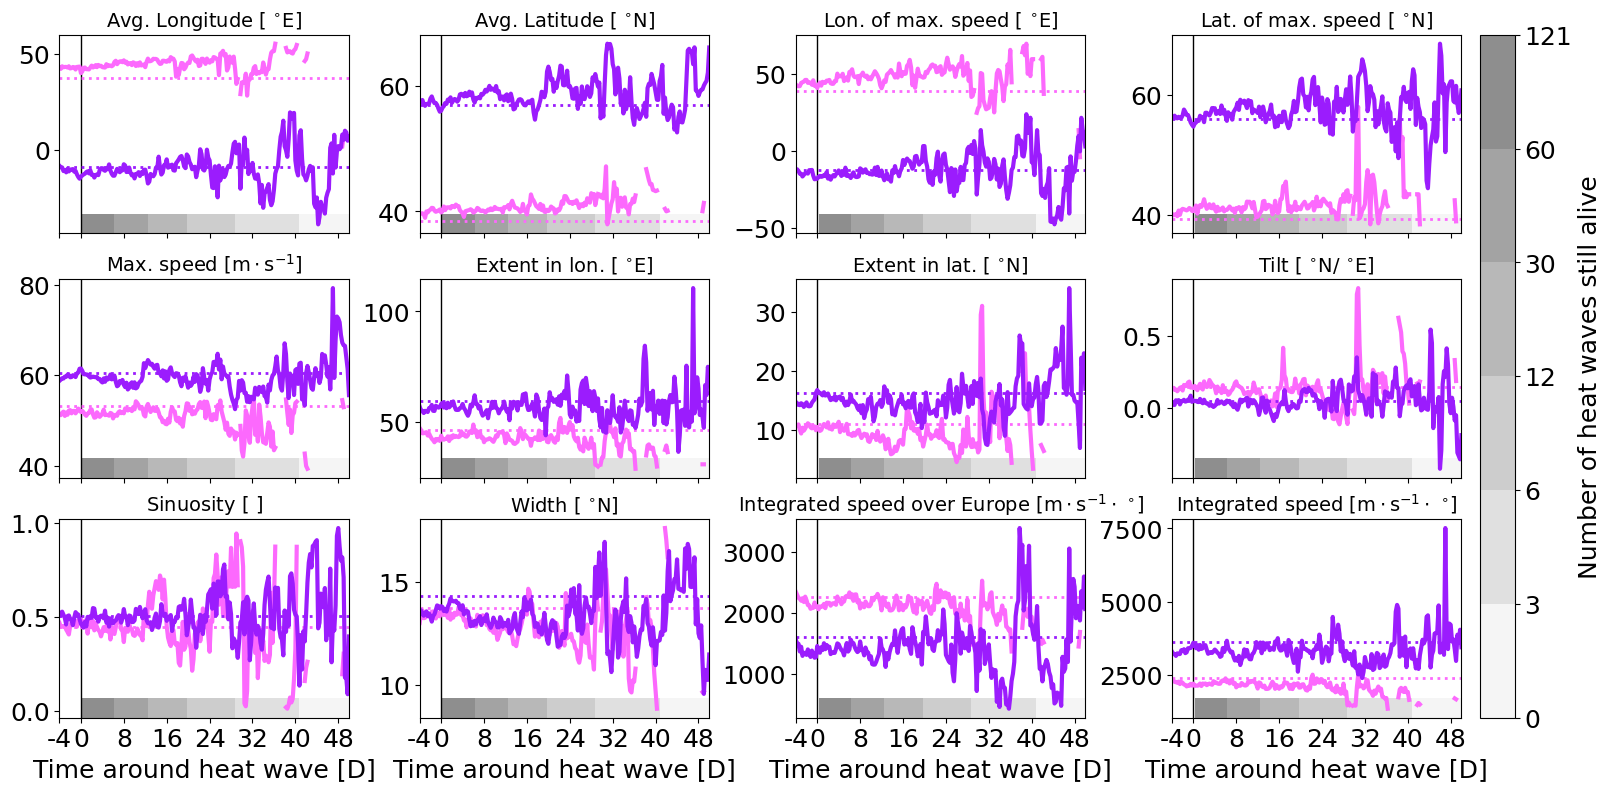

In [ ]:
data_vars = list(props_as_ds.data_vars)
fig, axes = plt.subplots(
    len(data_vars) // 4,
    4,
    figsize=(16, len(data_vars) // 4 * 2.6),
    constrained_layout=True,
    sharex='all'
)
dt = (props_as_ds.time.values[1] - props_as_ds.time.values[0]).astype('timedelta64[h]')
colors = COLORS5
n_hotspell = 1
x = props_as_ds_masked.time_around_beg.values.astype('timedelta64[h]')
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(props_as_ds_masked.jet.values):
        this_da = props_as_ds_masked[varname].loc[..., jet]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim='heat_wave').values
        # ax.plot(
        #     x,
        #     props_as_ds_masked[varname].loc[n_hotspell, :, jet].values.squeeze(),
        #     color=colors[j], lw=2,
        #     alpha=0.6,
        #     ls='solid'
        # )
        ax.plot(x, mean, color=colors[j], lw=3, ls='solid')
        mean_all = props_as_ds[varname].sel(jet=jet).mean(dim='time').values
        ax.plot(x, [mean_all] * len(this_da.time_around_beg), color=colors[j], lw=2, ls='dotted')
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='solid', alpha=0.6),
    Line2D([0], [0], color='black', lw=3, linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted'),
    Line2D([0], [0], color=colors[0], lw=3),
    Line2D([0], [0], color=colors[1], lw=3),
]
handles = [
    f'{props_as_ds_masked.absolute_time[n_hotspell, 0].dt.year.values} event', f'All heat waves', f'Mean of index',
    'Subtropical jet',
    'Polar jet'
]
# axes.ravel()[-1].legend(custom_lines[:], handles[:], ncol=1, framealpha=1.)
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim='heat_wave').values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', np.vstack(
        [cmap(np.linspace(0.05, 0.3, 100)), cmap(np.linspace(0.3, 0.6, 100))]
    ), N=200
)
norm = BoundaryNorm([0, 3, 6, 12, 30, 60, alive_hotspells.max()], cmap.N)
indices = [0] + np.arange(16, len(x), 32).tolist()
ticks = x[indices].astype(int)
xlim = np.amin(x.astype(float)), np.amax(x.astype(float))
ticklabels = x.astype('timedelta64[D]').astype(int)[indices]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f'{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]', fontsize=14)
    ylim = np.asarray(ax.get_ylim())
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xlim(xlim)
    ax.set_xticks(ticks, ticklabels, ha='center')
    ax.vlines(0, *ylim, color='black', lw=1, ls='solid', zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel('Number of heat waves still alive')
for ax in axes[-1, :]:
    ax.set_xlabel('Time around heat wave [D]')
plt.savefig(f'{FIGURES}/jet_props_misc/jet_props_vs_hotspell.png', dpi=300)